In [68]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from PIL import Image
from tqdm import tqdm
import os
import math


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error


def show(x_test,target,idx,model):
    a=np.expand_dims(x_test[target+idx], axis=0)
    prd=model.predict(a)
    aa=[]
    for b in prd[0][-1]:
        bb=[]
        for c in b:
            bb.append([c,c,c])
        aa.append(bb)
    aa=np.array(aa)[:,:,:,0]
    if idx==0:
        predict=np.expand_dims(aa,axis=0)
    else:
        predict = np.concatenate((predict, np.expand_dims(aa,axis=0)), axis=0)
def MAPE(y_test, y_pred,vervose=1):
    # print(y_test.shape, y_pred.shape)
    all=(zip(y_test,y_pred))
    
    cnt=0
    cost=0
    up=0
    down=0
    for t,p in all:#t로나눠
        if t==0:
            # c=np.abs(t-p) / p
            continue
        else:
            c=np.abs(t-p) / t
            cnt+=1
            cost+=c
            if c>0.5:
                if t> 40:
                    up+=1
                else:
                    down+=1
    if vervose==1:
        print(f"up: {up}  down : {down}")
    return cost/cnt*100


def compute_metrics(original,predict,start,end):
    start-=1
    end-=1
    y=original[:,start:end,:,:]
    y_pred=predict[:,start:end,:,:]
    
    # mape=MAPE(y.reshape(-1,),y_pred.reshape(-1,))
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()

    mape=MAPE(y_flatten,y_pred_flatten,0)

    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return np.array([mse,mape,mae])



def metrics_(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()


    mape=MAPE(y_flatten,y_pred_flatten)
    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return [mse,mape,mae]

def metrics_jam(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100
    # 속도 40이하만 필터링
    y_filtered=y[y <40]
    y_pred_filtered=y_pred[y < 40]

    
    mape=MAPE(y_filtered,y_pred_filtered)
    mse=mean_squared_error(y_filtered,y_pred_filtered)
    mae=mean_absolute_error(y_filtered,y_pred_filtered)
    return [mse,mape,mae]

def _predict(models,i, x_test ,target):
    for idx in range(7):
        a=np.expand_dims(x_test[target+idx], axis=0)

        prd=models[i].predict(a)
        #gray에서 이미지보여주려고 ch3만듬
        all=[]
        #예측된거 마지막꺼만 가져옴
        for img in prd[0][-1]:
            pixel=[]
            for gray in img:
                pixel.append([gray,gray,gray])
            all.append(pixel)
        all=np.array(all)[:,:,:,0]
    
        if idx==0:
            predict=np.expand_dims(all,axis=0)
            
        else:
            predict = np.concatenate((predict, np.expand_dims(all,axis=0)), axis=0)
    return predict



def make_predict(models, model_num, x_test ,target,original):
    predicts=[]
    for i in range(model_num):
    
        predict=_predict(models,i,x_test,target)

        print()
        print(f"{i}번째")
        print("속도 전체 에러율")
        mse,mape,mae=metrics_(1-original[:,:,:,0],1-predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")
        print("속도 40이하 에러율")
        mse,mape,mae=metrics_jam(1-original[:,:,:,0],1-predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")

        #모든 모델 확인하기 위해 리스트에 저장
        predicts.append(predict)
    return predicts


# test all 2020

In [56]:


path="D:/npz_gray_7_64_fix"

models=[]
# models.append(keras.models.load_model('my_model_test_100_binary_crossentropy_0.001.h5'))
# models.append(keras.models.load_model('my_model_mse_1026_gray_batch16_win7.h5'))
# my_model_mse_1103_gray_batch16_win7_fil16


models.append(keras.models.load_model('fixversion_64_layer3_0.0001_mse.h5'))
models.append(keras.models.load_model('fixversion_64_layer3_0.001_mse.h5'))


# models.append(keras.models.load_model('fixversion_64_layer6_0.001_mse_d0.2.h5'))

# models.append(keras.models.load_model('fixversion_64_layer3_0.001_mse_d0.2.h5'))




0번째
속도 전체 에러율
up: 22  down : 109
rmse : 8.928739360988217 , mape : 12.866155340875112 , mae : 5.354482406280002
속도 40이하 에러율
up: 0  down : 107
rmse : 14.399579745683678 , mape : 47.67094231879725 , mae : 9.990568937039843

1번째
속도 전체 에러율
up: 18  down : 120
rmse : 8.86139816486041 , mape : 13.183896511972279 , mae : 5.354549915524694
속도 40이하 에러율
up: 0  down : 118
rmse : 14.58794660357269 , mape : 50.54621320525467 , mae : 10.608435298826624


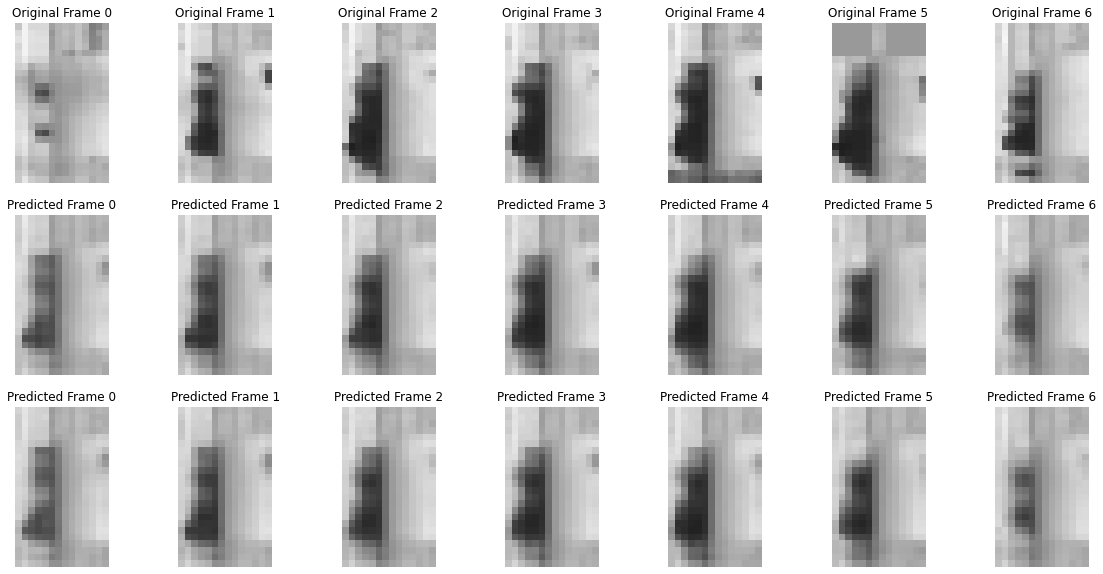

In [57]:
# 모든 모델 훈련시킨걸로 확인하기
x_test = np.load(f"{path}/batch/x/3.npz")['x']
target=5 # 
originals=[]
predicts=[]

model_num=2

#원본데이터
original=x_test[target+6]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    #inverse여서 1에서 빼준다
    ax.imshow((original[idx]))
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")




0번째
속도 전체 에러율
up: 26  down : 75
rmse : 9.518590473108848 , mape : 11.606400935242789 , mae : 5.65855271531309
속도 40이하 에러율
up: 0  down : 75
rmse : 15.071736675898439 , mape : 43.221392188865934 , mae : 9.844534196588118

1번째
속도 전체 에러율
up: 22  down : 76
rmse : 9.460849155897236 , mape : 11.67531846055328 , mae : 5.497883816464704
속도 40이하 에러율
up: 0  down : 76
rmse : 15.544434582449862 , mape : 45.859663604099595 , mae : 10.376809381438804


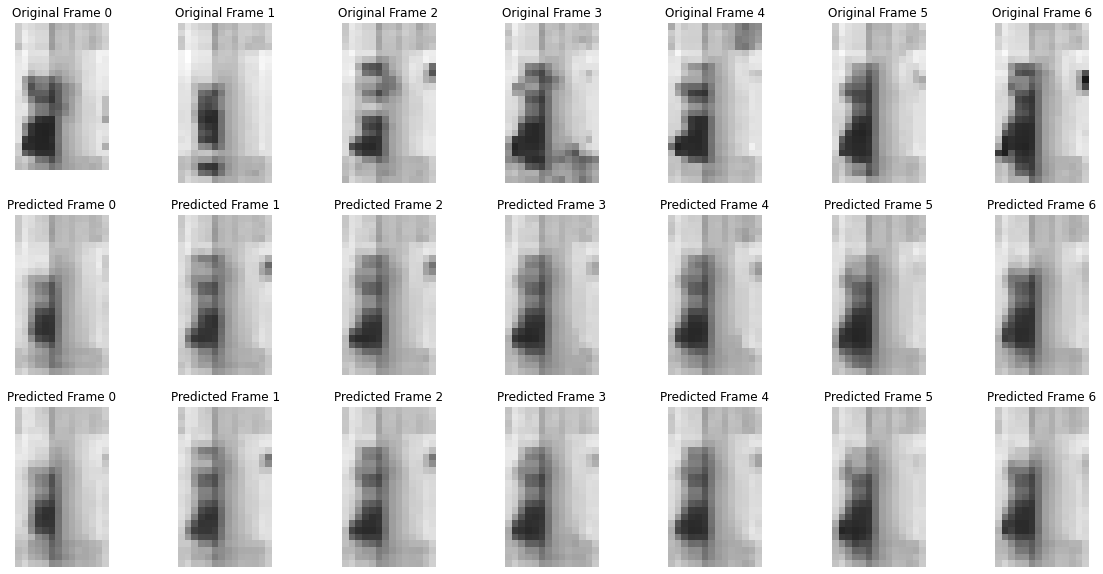

In [60]:
# 모든 모델 새로운데이터로 확인하기

x_test = np.load(f"{path}/2020/7.npz")['arr_0']
target=6 # 
originals=[]
predicts=[]
model_num=2

#원본데이터
original=x_test[target+6]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(original[idx])
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")


In [67]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=64
win=7
total=[]
for k in range(1):
    before_list=[]
    after_list=[]
    peak_list=[]
    rest_list=[]
    # for i in tqdm(list):
    x_test = np.load(f"{path}/2020/4.npz")['arr_0']
    for target in range(batch_size-win+1):


        predict=_predict(models,k,x_test,target)
        
        
        original=x_test[target+5]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        
        original=np.array(all)[:,:,:,:,0]

        #before peak hour - 7~12
        before=compute_metrics(original,predict,7,12)
        #peak 12~19
        peak=compute_metrics(original,predict,12,19)
        #after 19~21
        after=compute_metrics(original,predict,19,21)

        #rest 22~24 , 0~6
        y=original[:,21:23,:,:]
        y_pred=predict[:,21:23,:,:]
        # 22~24 0~6 시간대 합치기
        y=np.concatenate((y,original[:,0:5,:,:]),axis=1)
        y_pred=np.concatenate((y_pred,predict[:,0:5,:,:]),axis=1)
        # rest 에러 계산
        y=(y)*100
        y_pred=(y_pred)*100
        y_flatten=y.flatten()
        y_pred_flatten=y_pred.flatten()
        mape=MAPE(y_flatten,y_pred_flatten,0)
        mse=mean_squared_error(y_flatten,y_pred_flatten)
        mae=mean_absolute_error(y_flatten,y_pred_flatten)
        rest=[mse,mape,mae]
        
        #전체 저장
        before_list.append(before)
        after_list.append(after)
        peak_list.append(peak)
        rest_list.append(rest)


    total.append(np.array((np.array(before_list),np.array(peak_list),np.array(after_list),np.array(rest_list))))
total=np.array(total)

In [86]:
total.shape

(3, 4, 8, 3)

In [87]:
# mse,mape,mae
for i in range(3):
    print(f"{i}번째")
    print("before")
    print(np.mean(total[i][0],axis=0))
    print("peak")
    print(np.mean(total[i][1],axis=0))
    print("after")
    print(np.mean(total[i][2],axis=0))
    print("rest")
    print(np.mean(total[i][3],axis=0))
    print("표준편차")
    print("before")
    print(np.std(total[i][0],axis=0))
    print("peak")
    print(np.std(total[i][1],axis=0))
    print("after")
    print(np.std(total[i][2],axis=0))
    print("rest")
    print(np.std(total[i][3],axis=0))

0번째
before
[88.02205224 54.76142148  6.24326159]
peak
[53.13094357 38.49192635  4.74803171]
after
[56.52655777 40.43037943  5.12051787]
rest
[46.05930151 14.58099173  4.54109405]
표준편차
before
[4.52019861 5.98396626 0.15513846]
peak
[8.47684305 4.87884788 0.41080686]
after
[16.31194303 17.28289823  0.95516045]
rest
[19.51240555  3.44869555  1.10173766]
1번째
before
[104.59898904  71.33694625   6.39043284]
peak
[54.05484852 34.85404028  4.34047696]
after
[62.58078076 42.18389639  4.99850881]
rest
[43.04085891 14.55666661  4.25414162]
표준편차
before
[4.46327114 3.87157811 0.14893487]
peak
[6.81263427 8.59776735 0.38168687]
after
[13.64444345 21.67544348  0.82882135]
rest
[15.38196282  2.84814876  0.86565259]
2번째
before
[176.51354972  25.72661127   7.35901106]
peak
[106.1461434   21.42027286   5.31370302]
after
[80.61147227 26.87152873  5.31654628]
rest
[56.74741867 13.13462345  4.37762171]
표준편차
before
[4.75308827 1.64761689 0.16332184]
peak
[5.72095666 0.88374565 0.22022622]
after
[12.67401694 

In [ ]:
# mse,mape,mae
print("before")
print(np.mean(total2[0][0],axis=0))
print("peak")
print(np.mean(total2[0][1],axis=0))
print("after")
print(np.mean(total2[0][2],axis=0))
print("rest")
print(np.mean(total2[0][3],axis=0))
print("표준편차")
print("before")
print(np.std(total2[0][0],axis=0))
print("peak")
print(np.std(total2[0][1],axis=0))
print("after")
print(np.std(total2[0][2],axis=0))
print("rest")
print(np.std(total2[0][3],axis=0))

In [152]:
# mse,mape,mae
print("before")
print(np.mean(total[0][0],axis=0))
print("peak")
print(np.mean(total[0][1],axis=0))
print("after")
print(np.mean(total[0][2],axis=0))
print("rest")
print(np.mean(total[0][3],axis=0))
print("표준편차")
print("before")
print(np.std(total[0][0],axis=0))
print("peak")
print(np.std(total[0][1],axis=0))
print("after")
print(np.std(total[0][2],axis=0))
print("rest")
print(np.std(total[0][3],axis=0))

before
[30.09655889 30.41768951  4.20539981]
peak
[37.12391396 40.70233267  4.71663537]
after
[53.34358836 58.21013672  5.59674044]
rest
[24.09878969 12.29736551  3.89083012]
표준편차
before
[2.39452783 7.41034072 0.25136129]
peak
[3.20528185 8.51993725 0.20975115]
after
[ 6.59026685 11.01835599  0.42641541]
rest
[4.56067598 2.99438791 0.32004584]
